# 사람 분류
- albumentation 연습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import torchvision.models as models
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

# annotation file

In [4]:
data_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/4/data/annotations.csv')
data_df.head()

,filepath,asian,us,man,woman
0,asian_woman/asian_woman_87.jpg,1,0,0,1
1,asian_man/asian_man_88.jpg,1,0,1,0
2,us_woman/us_woman_80.jpg,0,1,0,1
3,us_man/us_man_107.jpg,0,1,1,0
4,us_man/us_man_95.jpg,0,1,1,0


In [5]:
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df.head()

,filepath,asian,us,man,woman
0,us_man/us_man_90.jpg,0,1,1,0
1,asian_man/asian_man_109.jpg,1,0,1,0
2,us_woman/us_woman_46.jpg,0,1,0,1
3,asian_man/asian_man_98.jpg,1,0,1,0
4,asian_man/asian_man_74.jpg,1,0,1,0


In [6]:
torch.tensor(data_df.iloc[0, 1:]).to(torch.float)

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/544792325.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(data_df.iloc[0, 1:]).to(torch.float)


tensor([0., 1., 1., 0.])

In [7]:
data_df.columns[1:].tolist()

['asian', 'us', 'man', 'woman']

# CustomDataset

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, data_df, classes, transforms):
        super().__init__()
        self.data = []
        self.root_path = root_path
        self.data_df = data_df
        self.transforms = transforms
        self.classes = classes

    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_path, self.data_df.iloc[idx, 0])).convert('RGB')
        img = self.transforms(img)
        classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생

        return img, classes

In [9]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/4/data', data_df, data_df.columns[1:].tolist(), transforms)

In [10]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# train, eval 함수

In [11]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Valid Loss: {valid_loss:.4f}, Valid F1: {valid_f1:.4f}')

    return model

# model

In [12]:
model = timm.create_model('inception_v3', num_classes=4, pretrained=True)
model

InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [13]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 10)

  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.7005, Train F1: 0.7190, Valid Loss: 0.7366, Valid F1: 0.6786


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.3883, Train F1: 0.8342, Valid Loss: 0.5321, Valid F1: 0.7893


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.2274, Train F1: 0.9126, Valid Loss: 0.6184, Valid F1: 0.8424


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.2280, Train F1: 0.9096, Valid Loss: 0.7130, Valid F1: 0.7986


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1548, Train F1: 0.9543, Valid Loss: 0.6024, Valid F1: 0.7884


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1430, Train F1: 0.9448, Valid Loss: 0.3379, Valid F1: 0.8535


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1099, Train F1: 0.9613, Valid Loss: 0.6218, Valid F1: 0.7916


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1200, Train F1: 0.9534, Valid Loss: 0.4979, Valid F1: 0.8624


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.0656, Train F1: 0.9796, Valid Loss: 0.7122, Valid F1: 0.8108


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1276, Train F1: 0.9538, Valid Loss: 0.6487, Valid F1: 0.7456


# test

In [14]:
model.eval()
test_loss = 0.0
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

test_loss /= len(test_dataloader)
test_f1 = f1_score(total_labels, total_preds, average='macro')

print(test_loss, test_f1)

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


0.557009756565094 0.7521038760179283


/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_87147/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


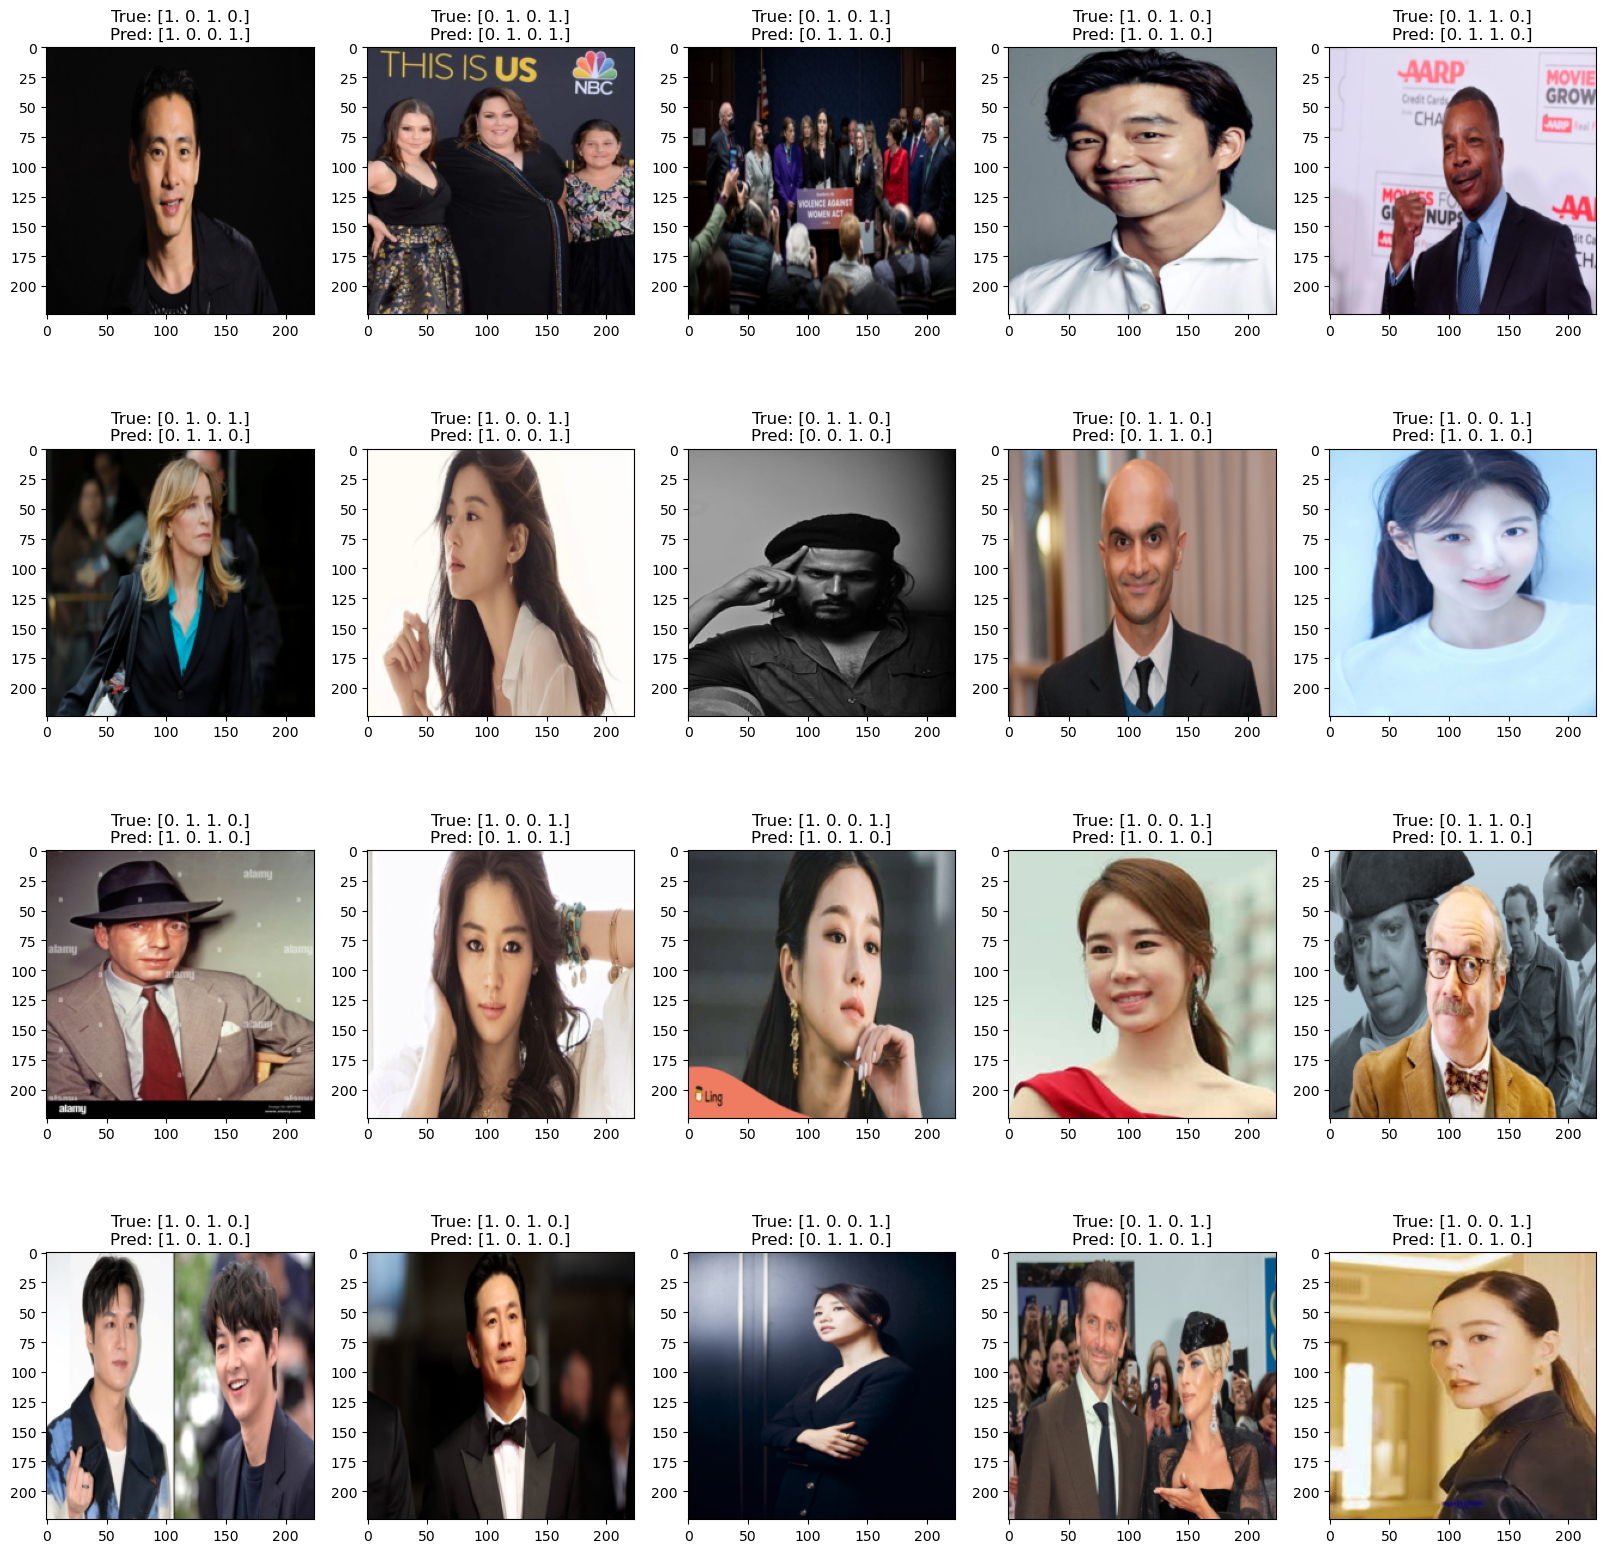

In [15]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')